# Steganography Detection using CNN in PyTorch
Dieses Notebook zielt darauf ab, ein Convolutional Neural Network (CNN) zu trainieren, um PNG-Bilder mit verstecktem Inhalt (z. B. JavaScript, PowerShell-Skripte und URLs) von normalen PNGs zu unterscheiden.
Dataset: 8,000 PNGs (512x512), die entweder „clean“ oder „kompromittiert“ sind (LSB-Steganographie).

# 1. Setup
Importiere die benötigten Bibliotheken und definiere die grundlegenden Parameter + Cuda einrichten

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

# Parameter
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
IMG_SIZE = (512, 512)

# Device-Erkennung (GPU oder CPU) für cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


# 2. Datensatz vorbereiten
Lade die Bilder und erstelle eine PyTorch Dataset-Klasse für den Umgang mit PNG-Dateien.

In [6]:
class SteganographyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        
        # Lade Bildpfade und Labels (0 = clean, 1 = kompromittiert)
        for label, subdir in enumerate(['clean', 'stego']):
            path = os.path.join(root_dir, subdir)
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                self.data.append((img_path, label))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformationen für die Bilder
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

# Datensätze laden
train_dataset = SteganographyDataset(root_dir='data/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = SteganographyDataset(root_dir='data/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 3. Modell definieren
Erstellen eines CNN-Modells zur Unterscheidung von „clean“ und „kompromittierten“ Bildern.

In [7]:
class LSBSteganalysisCNN(nn.Module):
    def __init__(self):
        super(LSBSteganalysisCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(0.5)
        """self.sigmoid = nn.Sigmoid()  da ich jetzt BSEWithLogitsLoss verwende (macht sigmoid intern)"""

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        """"x = self.sigmoid(self.fc2(x))"""
        self.fc2(x)
        return x

# Modellinitialisierung
model = LSBSteganalysisCNN().to(device)
"""criterion = nn.BCELoss()  # Binary Cross-Entropy Loss für binäre Klassifizierung"""
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 4. Training-Funktion

In [8]:
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for images, labels in loader:
        #für cuda
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Training Loss: {running_loss / len(loader):.4f}, Accuracy: {accuracy:.2f}%')
    return running_loss / len(loader), accuracy

# 5. Test-Funktion

In [9]:
def test(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            #für cuda
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Loss: {running_loss / len(loader):.4f}, Accuracy: {accuracy:.2f}%')
    return running_loss / len(loader), accuracy

# 6. Training und Evaluation

In [10]:
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}')
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    test_loss, test_accuracy = test(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch 1/20


ValueError: Target size (torch.Size([32])) must be the same as input size (torch.Size([32, 512]))

# 7. Ergebnisse visualisieren

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

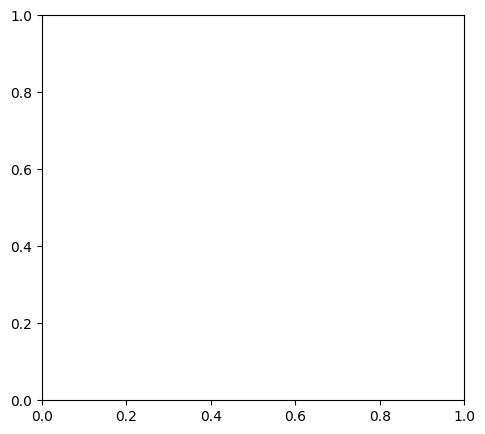

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(NUM_EPOCHS), train_losses, label='Train Loss')
plt.plot(range(NUM_EPOCHS), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(NUM_EPOCHS), train_accuracies, label='Train Accuracy')
plt.plot(range(NUM_EPOCHS), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

8. Modell speichern

In [5]:
torch.save(model.state_dict(), 'stegano_cnn.pth')
print("Modell gespeichert als 'stegano_cnn.pth'")

Modell gespeichert als 'stegano_cnn.pth'


In [ ]:
class SteganographyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        
        # Lade Bildpfade und Labels (0 = clean, 1 = kompromittiert)
        for label, subdir in enumerate(['clean', 'stego']):
            path = os.path.join(root_dir, subdir)
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                self.data.append((img_path, label))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformationen für die Bilder
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

# Datensätze laden
train_dataset = SteganographyDataset(root_dir='data/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = SteganographyDataset(root_dir='data/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# %% [markdown]
# ## 3. Modell definieren
# Erstellen eines CNN-Modells zur Unterscheidung von „clean“ und „kompromittierten“ Bildern.

# %%
class SteganoCNN(nn.Module):
    def __init__(self):
        super(SteganoCNN, self).__init__()
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 2)  # Binary classification

    def forward(self, x):
        return self.model(x)

model = SteganoCNN().to(device) #/to(device) ist für cuda
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# %% [markdown]
# ## 4. Training-Funktion

# %%
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for images, labels in loader:
        #für cuda
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Training Loss: {running_loss / len(loader):.4f}, Accuracy: {accuracy:.2f}%')
    return running_loss / len(loader), accuracy

# %% [markdown]
# ## 5. Test-Funktion

# %%
def test(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            #für cuda
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Loss: {running_loss / len(loader):.4f}, Accuracy: {accuracy:.2f}%')
    return running_loss / len(loader), accuracy

# %% [markdown]
# ## 6. Training und Evaluation

# %%
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}')
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    test_loss, test_accuracy = test(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

# %% [markdown]
# ## 7. Ergebnisse visualisieren

# %%
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(NUM_EPOCHS), train_losses, label='Train Loss')
plt.plot(range(NUM_EPOCHS), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(NUM_EPOCHS), train_accuracies, label='Train Accuracy')
plt.plot(range(NUM_EPOCHS), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# %% [markdown]
# ## 8. Modell speichern

# %%
torch.save(model.state_dict(), 'stegano_cnn.pth')
print("Modell gespeichert als 'stegano_cnn.pth'")

ModuleNotFoundError: No module named 'torch'